In [19]:
import gc
import math
import os
import pathlib
import pickle
import random
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

In [2]:
%matplotlib inline

In [3]:
train_df = pd.read_csv('../input/train/train.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int64
time_to_failure    float64
dtypes: float64(1), int64(1)
memory usage: 9.4 GB


In [ ]:
train_df.describe()

In [5]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [6]:
train_df.tail()

,acoustic_data,time_to_failure
629145475,7,9.759796
629145476,9,9.759796
629145477,10,9.759796
629145478,6,9.759796
629145479,5,9.759796


In [7]:
acoustic_data_df = train_df[train_df.columns.drop('time_to_failure')].astype(np.int32)

In [8]:
time_to_failure_df = train_df[train_df.columns.drop('acoustic_data')].astype(np.float32)

In [9]:
compressed_train_df = pd.concat([acoustic_data_df, time_to_failure_df], axis=1)

In [10]:
compressed_train_df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [11]:
compressed_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int32
time_to_failure    float32
dtypes: float32(1), int32(1)
memory usage: 4.7 GB


In [12]:
train_df = compressed_train_df

In [13]:
train_df.shape

(629145480, 2)

In [26]:
print(train_df.head())
print(train_df.tail())

   acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691
           acoustic_data  time_to_failure
629145475              7         9.759795
629145476              9         9.759795
629145477             10         9.759795
629145478              6         9.759795
629145479              5         9.759795


In [29]:
#train_df.reset_index()

In [30]:
#train_df.drop(columns=['index'], inplace=True)

In [14]:
#del acoustic_data_df 
#del time_to_failure_df
gc.collect()

18

In [23]:
def add_features(
        df,
        input_first_index=None,
        input_last_index=None,
        sample_size=150000,
        holdout_size=50000,
        smootch_windows_size = (3, 5, 7)
    ):
    if input_first_index == None or input_last_index == None:
        input_first_index = df.index.min()
        input_last_index = df.index.max() + 1
    
    print("input_first_index:", input_first_index)
    print("input_last_index:", input_last_index)
    
    sample_indexes = random.sample(range(input_first_index, input_last_index), sample_size)
    sample_indexes.sort()
    
    print("min(sample_indexes):", min(sample_indexes))
    print("max(sample_indexes):", min(sample_indexes))
    
    smootch_feature_names = ['smootch_mean_ws_{}'.format(window_size) for window_size in smootch_windows_size]
    acoustic_data_series = df['acoustic_data']
    full_data_indexes = tuple(acoustic_data_series.index.tolist())

    sample_df = df.iloc[sample_indexes]

    sample_df.reset_index(inplace=True)
    sample_df.drop(columns=['index'], inplace=True)

    output_first_index = 0
    output_last_index = len(sample_df) - 1
    
    begin_indexes_set = set()
    end_indexes_set = set()
    
    start_time = time.time()
   
    sample_df_len = sample_df.shape[0]
    for window_size, feature_name in zip(smootch_windows_size, smootch_feature_names):

        feature_values_list = list(range(sample_size))

        half_window_size = window_size // 2

        sample_begin_indexes = sample_indexes[:half_window_size]
        full_data_begin_indexes = set(df.index[sample_begin_indexes].tolist())
        min_full_data_index = min(full_data_indexes)
        
        in_window_full_data_begin_indexes = set(range(input_first_index, input_first_index + half_window_size))              
        in_window_begin_indexes = full_data_begin_indexes.intersection(
            in_window_full_data_begin_indexes
        )
        
        sample_end_indexes = sample_indexes[-half_window_size:]
        full_data_end_indexes = set(df.index[sample_end_indexes].tolist())
        max_full_data_index = max(full_data_end_indexes) + 1
        
        in_window_full_data_end_indexes = set(range(input_last_index - half_window_size, input_last_index))        
        in_window_end_indexes = full_data_end_indexes.intersection(
            in_window_full_data_end_indexes
        )
        if in_window_begin_indexes:
            begin_indexes_set = begin_indexes_set.union(in_window_begin_indexes)
            for i, b_idx in enumerate(sorted(tuple(in_window_begin_indexes))):
                value = sample_df.iloc[i]['acoustic_data']
                temp = acoustic_data_series.iloc[input_first_index:input_first_index + window_size].mean()
                value = value - temp
                feature_values_list[output_first_index + i] = value
                
        if in_window_end_indexes:
            end_indexes_set = end_indexes_set.union(in_window_end_indexes)
            for i, e_idx in enumerate(sorted(tuple(in_window_end_indexes))):
                value = sample_df.iloc[output_last_index - i]['acoustic_data']
                temp = acoustic_data_series.iloc[input_last_index - window_size:].mean()
                value = value - temp
                feature_values_list[output_last_index - i] = value
                
        first_regular_idx = len(begin_indexes_set)
        last_regular_idx = sample_df_len - len(end_indexes_set)
        for i in range(first_regular_idx, last_regular_idx):
            sample_idx = sample_indexes[i]
            feature_values_list[i] = acoustic_data_series.iloc[
                sample_idx - half_window_size:sample_idx + half_window_size
            ].mean()
        sample_df[feature_name] = feature_values_list
        
    holdout_df = None
    if holdout_size > 0:
        holdout_indexes = np.random.randint(0, sample_df.shape[0], holdout_size)
        holdout_df = sample_df.iloc[holdout_indexes]
        holdout_df.reset_index(inplace=True)
        holdout_df.drop(columns=['index'], inplace=True)
        train_indexes = sorted(tuple(set(sample_df.index).difference(set(holdout_indexes))))
        sample_df = sample_df.iloc[train_indexes]
        sample_df.reset_index(inplace=True)
        sample_df.drop(columns=['index'], inplace=True)
    print("Full calculation feature value time (with slicing) {} min:".format((time.time() - start_time) / 60))
    return sample_df, holdout_df

In [16]:
train_df_sample = train_df[::40]

In [17]:
train_df_sample.shape

(15728637, 2)

In [32]:
train_df_sample.reset_index(inplace=True)

In [33]:
train_df_sample.drop(columns=['index'], inplace=True)

In [34]:
%%time
featured_train_df_sample = add_features(train_df_sample, sample_size=5200000, holdout_size=0, smootch_windows_size = (3, 5, 7, 9, 11))

input_first_index: 0
input_last_index: 15728637
min(sample_indexes): 0
max(sample_indexes): 0
Full calculation feature value time (with slicing) 97.81985729535421 min:
CPU times: user 1h 38min 4s, sys: 36.3 s, total: 1h 38min 40s
Wall time: 1h 38min 8s


In [35]:
type(featured_train_df_sample)

tuple

In [36]:
featured_train_df_sample, _ = featured_train_df_sample

In [37]:
featured_train_df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200000 entries, 0 to 5199999
Data columns (total 7 columns):
acoustic_data         int32
time_to_failure       float32
smootch_mean_ws_3     float64
smootch_mean_ws_5     float64
smootch_mean_ws_7     float64
smootch_mean_ws_9     float64
smootch_mean_ws_11    float64
dtypes: float32(1), float64(5), int32(1)
memory usage: 238.0 MB


In [38]:
featured_train_df_sample.head()

,acoustic_data,time_to_failure,smootch_mean_ws_3,smootch_mean_ws_5,smootch_mean_ws_7,smootch_mean_ws_9,smootch_mean_ws_11
0,12,1.469100,6.0,5.40,6.428571,6.000,5.636364
1,7,1.469100,8.5,7.75,5.166667,5.250,5.900000
2,6,1.469099,5.0,4.25,5.500000,5.750,6.200000
3,6,1.469099,6.0,5.75,5.000000,5.625,6.100000
4,6,1.469099,6.0,7.00,7.000000,7.375,7.300000


In [39]:
featured_train_df_sample.to_csv("featured_train_df_sample.csv", index=False)

No handles with labels found to put in legend.


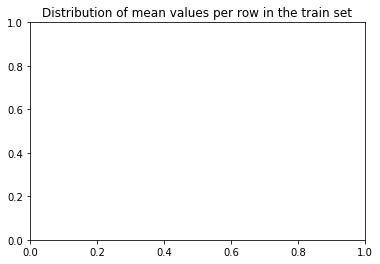

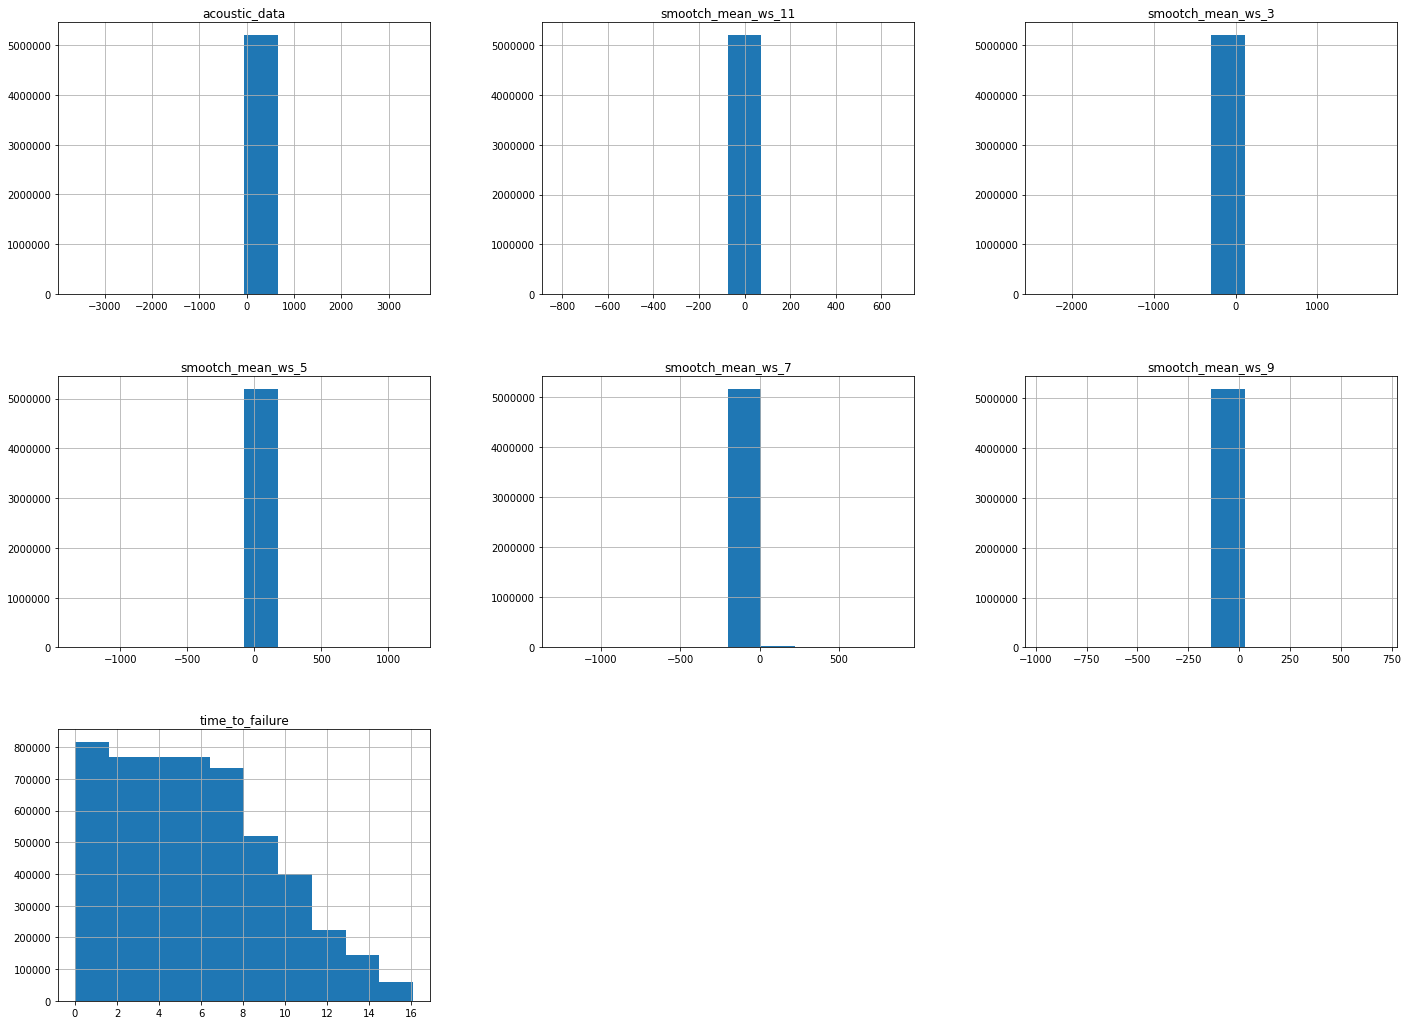

In [46]:
#plt.figure(figsize=(24, 18))
features = featured_train_df_sample.columns.drop('time_to_failure')
#plt.title("Distribution of mean values per row in the train and test set")
plt.title("Distribution of mean values per row in the train set")
#sns.distplot(featured_train_df_sample[features].mean(axis=1), color="blue", kde=True, bins=120, label='train')
#sns.distplot(featured_train_df_sample[features], kde=True, bins=120, label='train')
#sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
featured_train_df_sample.hist(figsize=(24, 18))
plt.legend()
plt.show()

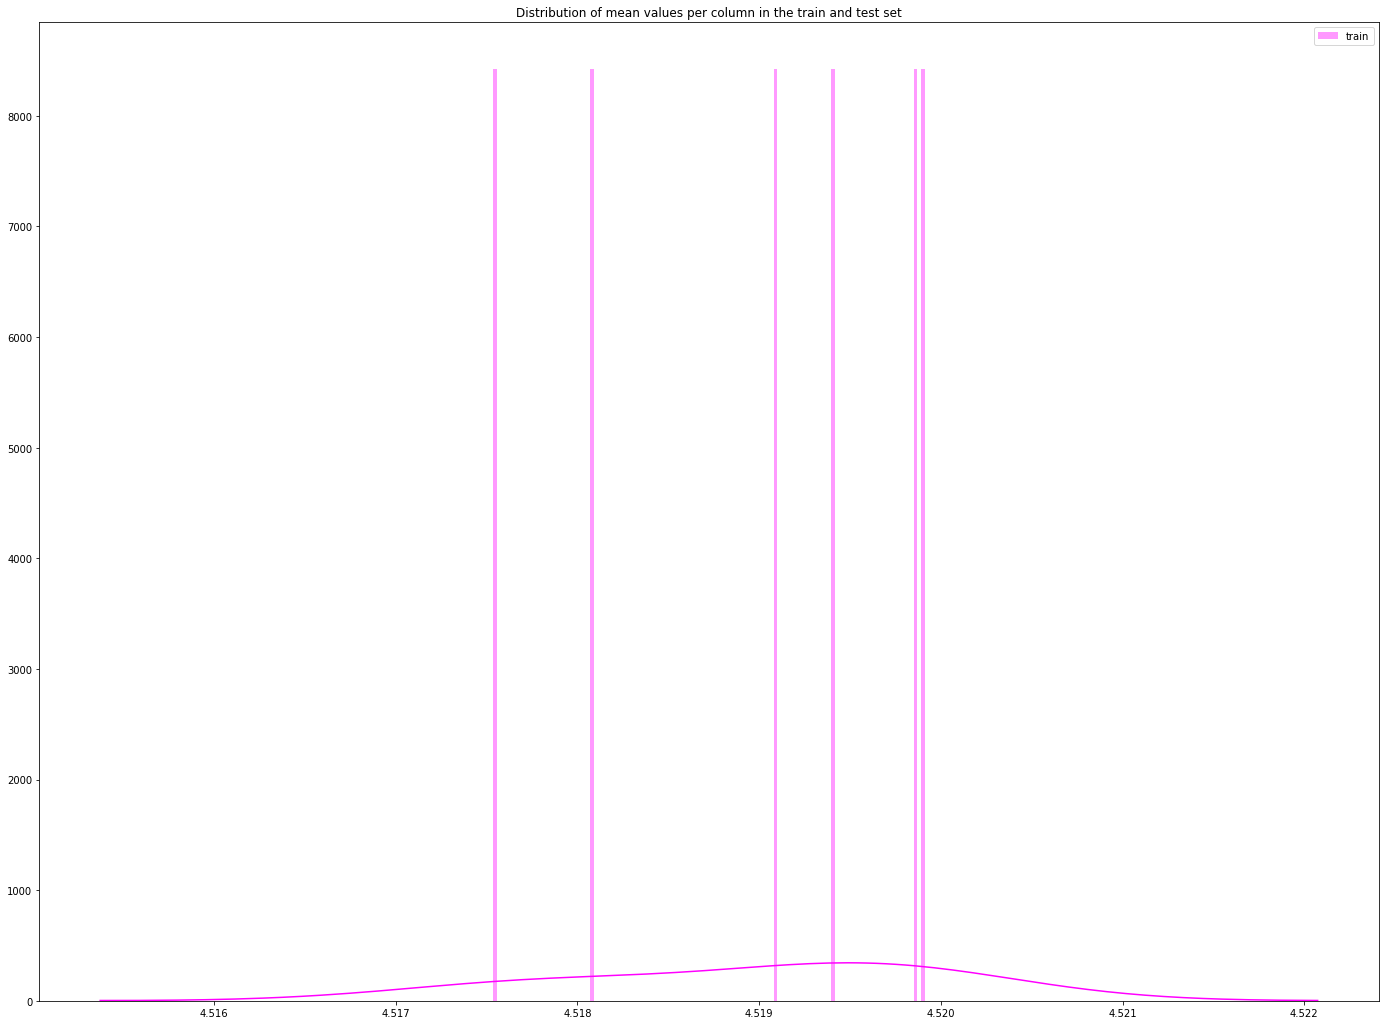

In [42]:
features = featured_train_df_sample.columns.drop('time_to_failure')
plt.figure(figsize=(24, 18))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(featured_train_df_sample[features].mean(axis=0), color="magenta", kde=True,bins=120, label='train')
#sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

No handles with labels found to put in legend.


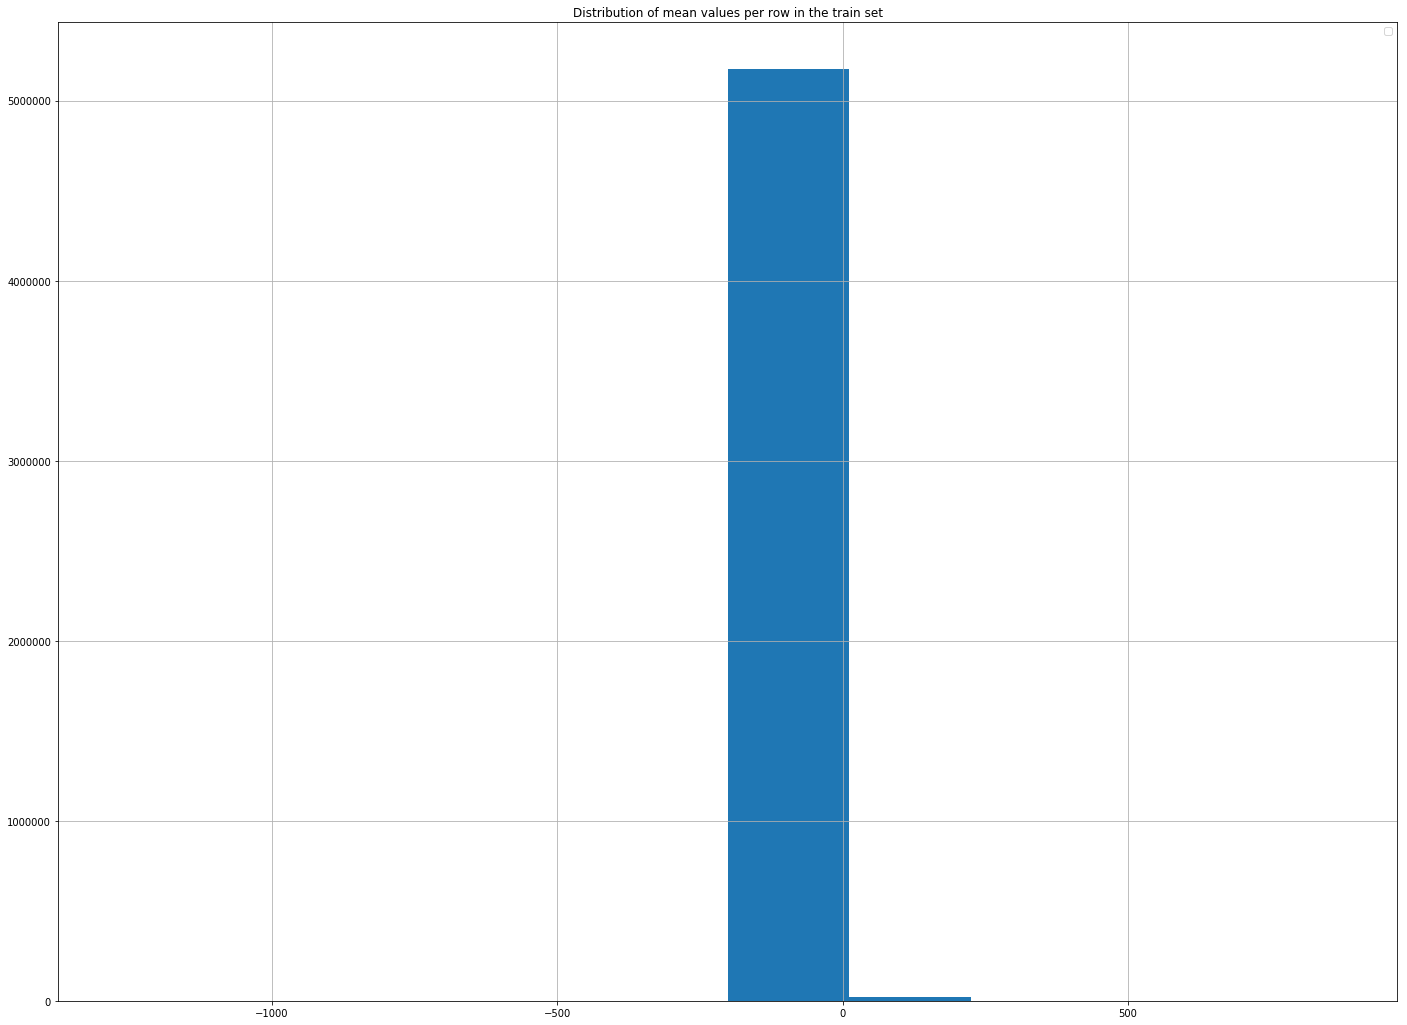

In [47]:
#plt.figure(figsize=(24, 18))
features = featured_train_df_sample.columns.drop('time_to_failure')
#plt.title("Distribution of mean values per row in the train and test set")
plt.title("Distribution of mean values per row in the train set")
#sns.distplot(featured_train_df_sample[features].mean(axis=1), color="blue", kde=True, bins=120, label='train')
#sns.distplot(featured_train_df_sample[features], kde=True, bins=120, label='train')
#sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
featured_train_df_sample['smootch_mean_ws_7'].hist(figsize=(24, 18))
plt.legend()
plt.show()

No handles with labels found to put in legend.


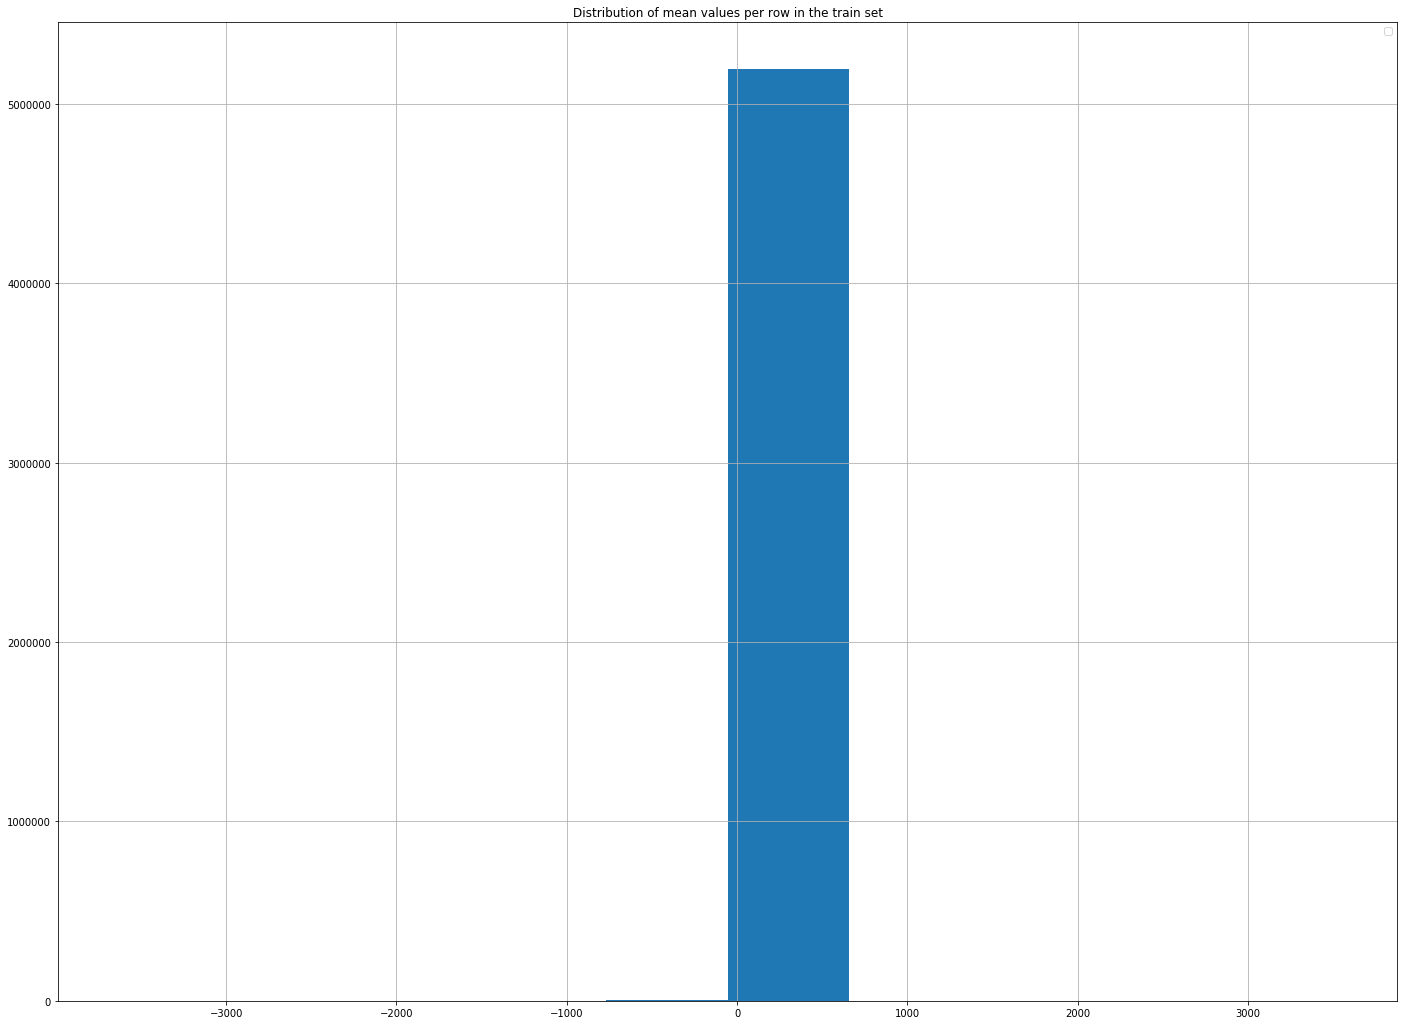

In [48]:
#plt.figure(figsize=(24, 18))
features = featured_train_df_sample.columns.drop('time_to_failure')
#plt.title("Distribution of mean values per row in the train and test set")
plt.title("Distribution of mean values per row in the train set")
#sns.distplot(featured_train_df_sample[features].mean(axis=1), color="blue", kde=True, bins=120, label='train')
#sns.distplot(featured_train_df_sample[features], kde=True, bins=120, label='train')
#sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
featured_train_df_sample['acoustic_data'].hist(figsize=(24, 18))
plt.legend()
plt.show()

In [49]:
featured_train_df_sample.corr()

,acoustic_data,time_to_failure,smootch_mean_ws_3,smootch_mean_ws_5,smootch_mean_ws_7,smootch_mean_ws_9,smootch_mean_ws_11
acoustic_data,1.000000,-0.000773,0.609116,0.292063,0.268041,0.184800,0.176732
time_to_failure,-0.000773,1.000000,-0.001444,-0.001714,-0.001813,-0.001786,-0.002705
smootch_mean_ws_3,0.609116,-0.001444,1.000000,0.535594,0.471793,0.373078,0.354260
smootch_mean_ws_5,0.292063,-0.001714,0.535594,1.000000,0.686950,0.634969,0.562152
smootch_mean_ws_7,0.268041,-0.001813,0.471793,0.686950,1.000000,0.800592,0.716363
smootch_mean_ws_9,0.184800,-0.001786,0.373078,0.634969,0.800592,1.000000,0.817353
smootch_mean_ws_11,0.176732,-0.002705,0.354260,0.562152,0.716363,0.817353,1.000000


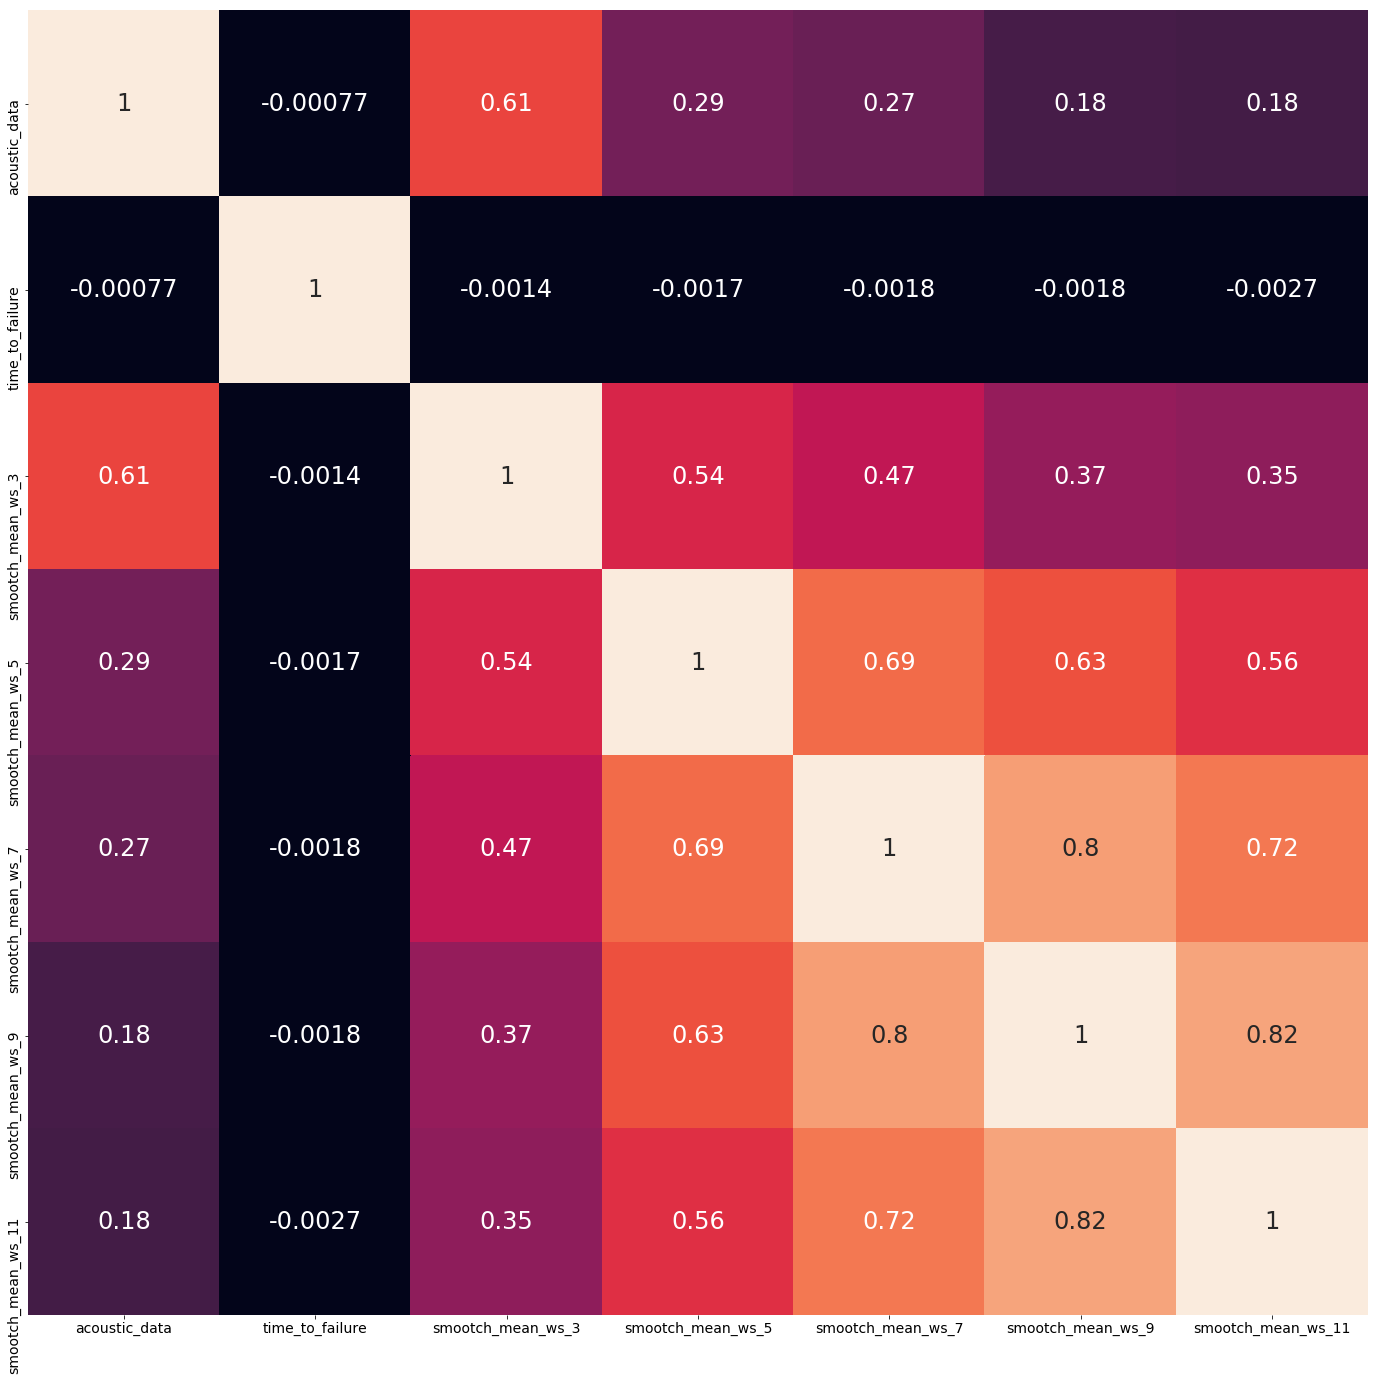

In [51]:
plt.figure(figsize=(24, 24))
heatmap_fig = sns.heatmap(
    featured_train_df_sample.corr(),
    annot=True, annot_kws={"size":24},
    cbar=False
)
for item in heatmap_fig.get_xticklabels():
    item.set_fontsize(14)
for item in heatmap_fig.get_yticklabels():
    item.set_fontsize(14)
for item in heatmap_fig.get_label():
    item.set_fontsize(14)